In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 414 (delta 104), reused 79 (delta 79), pack-reused 250
Receiving objects: 100% (414/414), 70.33 MiB | 21.34 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Checking out files: 100% (56/56), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=b4355952007bb8e3738be084c1220c50e2b01f4a49e5ae60415793fd60d22dac
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [2]:
from dul_2021.utils.hw13_utils import *

In [3]:
import os
import numpy as np
import copy
from itertools import chain
from typing import List, Any, Tuple

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
from torch.utils import data
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from tqdm.notebook import tqdm, trange

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



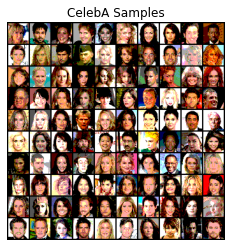

In [5]:
visualize_q1_data()

## Part (a): RealNVP


Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 256, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=128, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=128
  relu()
  conv2d(n_filters, n_filters=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # todo: calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.40 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [6]:
def squeeze(x: torch.Tensor) -> torch.Tensor:
    # B x C x H x W -> B x 4C x H/2 x W/2
    B, C, H, W = x.shape
    x = x.reshape(B, C, H, W // 2, 2) 
    x = x.reshape(B, C, H // 2, 2, W // 2, 2)
    x = x.permute(0, 1, 3, 5, 2, 4)
    x = x.reshape(B, C * 4, H // 2, W // 2)
    return x


def unsqueeze(x: torch.Tensor) -> torch.Tensor: 
    # B x 4C x H/2 x W/2 -> B x C x H x W
    B, C, H, W = x.shape
    x = x.reshape(B, C // 4, 2, 2, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3)
    x = x.reshape(B, C // 4, H * 2, W, 2)
    x = x.reshape(B, C // 4, H * 2, W * 2)
    return x

In [14]:
class ActNorm(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1))
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1))
        
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x: torch.Tensor, reverse: bool = False) -> torch.Tensor:
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
          if not self.initialized:
              self.log_scale.data =  -torch.log(torch.std(x, dim=(0, 2, 3))).reshape(1, self.n_channels, 1, 1)
              self.shift.data = -torch.mean(x, dim=(0, 2, 3), keepdim=True) * torch.exp(self.log_scale.data)
              self.initialized = True
            
        return x * torch.exp(self.log_scale) + self.shift, self.log_scale

In [15]:
class ResnetBlock(nn.Module): 
    def __init__(self, n_filters: int):
        super().__init__()
        self.block = nn.Sequential( 
            nn.Conv2d(n_filters, n_filters, (1, 1), stride=1, padding=0), 
            nn.ReLU(), 
            nn.Conv2d(n_filters, n_filters, (3, 3), stride=1, padding=1), 
            nn.ReLU(), 
            nn.Conv2d(n_filters, n_filters, (1, 1), stride=1, padding=0))

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return x + self.block(x)

class SimpleResnet(nn.Module): 
    def __init__(self, 
                 in_channels: int = 3, 
                 out_channels: int = 6,
                 n_filters: int = 128, 
                 n_blocks: int = 8): 
        super().__init__() 
        layers = [nn.Conv2d(in_channels, n_filters, (3, 3), stride=1, padding=1), 
                  nn.ReLU()]
        layers.extend([ResnetBlock(n_filters) for _ in range(n_blocks)])
        layers.extend([nn.ReLU(), 
                       nn.Conv2d(n_filters, out_channels, (3, 3), stride=1, padding=1)])
        self.resnet = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.resnet(x)

In [16]:
class AffineCheckerboardTransform(nn.Module):
    def __init__(self, top_left: float = 1.0):
        super().__init__()
        self.mask = np.arange(32).reshape(-1, 1) + np.arange(32)
        self.mask = (top_left + self.mask) % 2
        self.mask = torch.tensor(self.mask.reshape(-1, 1, 32, 32), 
                                 dtype=torch.float, device=device)
        
        self.scale = nn.Parameter(torch.zeros(1))
        self.scale_shift = nn.Parameter(torch.zeros(1))
        self.resnet = SimpleResnet()

    def forward(self, x: torch.Tensor, reverse: bool = False) -> torch.Tensor: 
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)

        log_s, t = self.resnet(x * mask).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if not reverse: 
            x = x * torch.exp(log_s) + t
        else: 
            x = (x - t) * torch.exp(-log_s)

        return x, log_s


class AffineChannelTransform(nn.Module): 
    def __init__(self, modify_top: bool):
        super().__init__()
        self.modify_top = modify_top
        self.scale = nn.Parameter(torch.zeros(1))
        self.scale_shift = nn.Parameter(torch.zeros(1))
        self.resnet = SimpleResnet(in_channels=6, out_channels=12)

    def forward(self, x: torch.Tensor, reverse: bool = False) -> torch.Tensor:
        _, n_channels, _, _ = x.shape

        on, off = x.split(n_channels // 2, dim=1)
        if not self.modify_top: 
            on, off = off, on

        log_s, t = self.resnet(off).split(n_channels // 2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift

        if not reverse: 
            on = on * torch.exp(log_s) + t
        else: 
            on = (on - t) * torch.exp(-log_s)

        if self.modify_top:
            return torch.cat([on, off], dim=1), torch.cat([log_s, torch.zeros_like(log_s)], dim=1)
            
        return torch.cat([off, on], dim=1), torch.cat([torch.zeros_like(log_s), log_s], dim=1)

In [17]:
class RealNVP(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))

        self.layer_1 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3),
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3)
        ])

        self.layer_2 = nn.ModuleList([
            AffineChannelTransform(True),
            ActNorm(12),
            AffineChannelTransform(False),
            ActNorm(12),
            AffineChannelTransform(True),
            ActNorm(12)
        ])

        self.layer_3 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3),
            AffineCheckerboardTransform(1.0), 
        ])

    def flow(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]: 
        z, log_det = x, torch.zeros_like(x)

        for op in self.layer_1:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det

        z, log_det = squeeze(z), squeeze(log_det)
        for op in self.layer_2:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det

        z, log_det = unsqueeze(z), unsqueeze(log_det)
        for op in self.layer_3:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det

        return z, log_det

    def invert_flow(self, z: torch.Tensor) -> torch.Tensor: 
        x = z

        for op in reversed(self.layer_3):
            x, _ = op.forward(x, reverse=True)

        x = squeeze(x)
        for op in reversed(self.layer_2):
            x, _ = op.forward(x, reverse=True)

        x = unsqueeze(x)
        for op in reversed(self.layer_1):
            x, _ = op.forward(x, reverse=True)

        return x

    def log_prob(self, x: torch.Tensor) -> torch.Tensor: 
        z, log_det = self.flow(x)
        log_prob = torch.sum(self.prior.log_prob(z), (1, 2, 3)) + torch.sum(log_det, (1, 2, 3)) 
        return log_prob

    def sample(self, num_samples: int) -> torch.Tensor: 
        z = self.prior.sample((num_samples, 3, 32, 32))
        x = self.invert_flow(z)
        return x

In [18]:
def reverse_preprocess(x): 
    x = F.sigmoid(x)
    x -= 0.05
    x / 0.9 
    return x

def forward_preprocess(x, dequantize=True): 
    if dequantize: 
        x += Uniform(0.0, 1.0).sample(x.shape).to(device)

    x /= 4.0
    x *= 0.9
    x += 0.05
    logit = torch.log(x) - torch.log(1.0 - x)
    log_det = F.softplus(logit) + F.softplus(-logit) + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(4.0))
    log_det = torch.sum(log_det, dim=(1, 2, 3))
    return logit, log_det


def test_epoch(model, loader) -> float: 
    model.eval()
    losses = []

    for batch in loader: 
        with torch.no_grad(): 
            batch = batch.float().to(device)
            batch, log_det = forward_preprocess(batch)
            log_prob = model.log_prob(batch)
            log_prob += log_det

            loss = -torch.mean(log_prob) / (3 * 32 * 32)
            losses.append(loss.item())

    return np.mean(losses)


def train_epoch(model, loader, optimizer) -> List[float]: 
    model.train()
    losses = []

    for batch in tqdm(loader, desc="Batch", leave=False): 
        batch = batch.float().to(device)
        batch, log_det = forward_preprocess(batch)
        log_prob = model.log_prob(batch)
        log_prob += log_det

        loss = -torch.mean(log_prob) / (3 * 32 * 32)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        losses.append(loss.item())

    return np.array(losses)


def train(model, train_data, test_data, 
          n_epochs=100, lr=5e-4, batch_size=64) -> Tuple[np.ndarray, np.ndarray]: 
    train_losses, test_losses = [], []
    test_loader = data.DataLoader(train_data.transpose(0, 3, 1, 2).astype("float"), 
                                  batch_size=batch_size, shuffle=True)
    train_loader = data.DataLoader(test_data.transpose(0, 3, 1, 2).astype("float"), 
                                   batch_size=batch_size, shuffle=False)
    optimizer = opt.Adam(model.parameters(), lr=lr)

    for _ in trange(n_epochs, desc="Epoch"): 
        epoch_losses = train_epoch(model, train_loader, optimizer) 
        test_loss = test_epoch(model, test_loader)

        train_losses.extend(epoch_losses)
        test_losses.append(test_loss)

    return train_losses, test_losses


def sample(model, num_samples) -> np.ndarray:
    model.eval()
    with torch.no_grad(): 
        raw_samples = model.sample(num_samples).cpu()
        samples = reverse_preprocess(raw_samples)
        return samples.cpu().detach().numpy()


def interpolate(model, data): 
    model.eval()
    indices = np.random.choice(len(data), size=10, replace=False)
    images = torch.tensor(data[indices], dtype=torch.float, device=device)
    
    with torch.no_grad(): 
        x, _ = forward_preprocess(images, dequantize=False)
        zs, _ = model.flow(x)
        latents = []

        for i in range(0, 10, 2): 
            a, b = zs[i], zs[i + 1]
            diff = (b - a) / 5.0

            latents.append(a)
            for j in range(1, 5): 
                latents.append(a + diff * float(j))
            latents.append(b)

        latents = torch.cat(latents, dim=0)
        result = model.invert_flow(latents)
        result = reverse_preprocess(result)

    return result.cpu().numpy()

In [19]:
def q1_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  model = RealNVP().to(device)
  train_losses, test_losses = train(model, train_data, test_data, n_epochs=1)
  samples = sample(model, 100).transpose(0, 2, 3, 1)
  interpolations = interpolate(model, test_data).transpose(0, 2, 3, 1)
  return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



In [21]:
q1_save_results(q1_a, 'a')

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/107 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: ignored

In [ ]:
q1_save_results(q1_a, 'a')

## Part (b): Exploring bad masking schemes

The choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

### Solution

In [ ]:
def q1_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(q1_b, 'b')

## Bonus 1: Multiscale RealNVP
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b1, 'bonus1')

## Bonus 2: Glow
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b2, 'bonus2')